### AI Health Assistant - Supervisor Agent


A personalized digital wellness coach that feels like a team of specialized experts working together to improve your fitness, nutrition, and mental health.


- **Agents**:
    - `Fitness Agent`: Builds a workout plan.
    - `Dietician Agent`: Creates healthy meal plans.
    - `Mental Health Agent`: Gives basic mindfulness or stress-reducing practices.

In [1]:
from langchain_core.messages import HumanMessage,AIMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain.prompts import PromptTemplate
from IPython.display import display, Image
from typing import Annotated, Literal
from langchain_ollama import ChatOllama

from typing_extensions import TypedDict
from langchain.tools import tool
from langgraph.types import Command
import requests
import random
import uuid
import os

In [2]:
fitness_api_key = os.getenv("EXERCISE_API_KEY")
diet_api_key = os.getenv("DIET_API_KEY")

#### Define State

In [3]:

class State(MessagesState):
    next: str

### Define Tools

##### Create Fitness Tool

In [5]:
class FitnessData:

    def __init__(self):
        self.base_url = "https://api.api-ninjas.com/v1/exercises"
        self.api_key = fitness_api_key
       
    
    def get_muscle_groups_and_types(self):
     
        muscle_targets = {
                'full_body': ["abdominals", "biceps", "calves", "chest", "forearms", "glutes",
                    "hamstrings", "lower_back", "middle_back", "quadriceps",
                    "traps", "triceps", "adductors"
                    ],
                'upper_body': ["biceps", "chest", "forearms", "lats", "lower_back", "middle_back", "neck", "traps", "triceps" ],
                'lower_body': ["adductors", "calves", "glutes", "hamstrings", "quadriceps"]
            }
        exercise_types = {'types':["powerlifting","strength", "stretching", "strongman"]}

        return muscle_targets, exercise_types


    def fetch_exercises(self, type, muscle, difficulty):
        headers = {
            'X-Api-Key':self.api_key
        }
        params= {
            'type': type,
            'muscle': muscle,
            'difficulty': difficulty
            }
        try:
            response = requests.get(self.base_url, headers=headers,params=params)
            result = response.json()
            if not result:
                print(f"No exercises found for {muscle}")
            return result
        except requests.RequestException as e:
            print(f"Request failed: {e}")
            return []
        
       

    def generate_workout_plan(self, query='full_body', difficulty='intermediate'):
        output=[]
        muscle_targets, exercise_types = self.get_muscle_groups_and_types()
        muscle = random.choice(muscle_targets.get(query))
        type = random.choice(exercise_types.get('types'))
        result = self.fetch_exercises('stretching', muscle, difficulty)
        print(result)
        limit_plan = result[:3]
        for i, data in enumerate(limit_plan):
            if data not in output:
                output.append(f"Exercise {i+1}: {data['name']}")
                output.append(f"Muscle: {data['muscle']}")
                output.append(f"Instructions: {data['instructions']}")
              
        return output
            





In [7]:
@tool
def fitness_data_tool(query: Annotated[str, "This input will either be full_body, upper_body \
                                        or lower_body exercise plan"]):
    """use this tool to get fitness or workout plan for a user.
    The workout name provided serves as your input  \
                                        """
    fitness_tool = FitnessData()
    result = fitness_tool.generate_workout_plan(query)

    return result

In [6]:
fitness = FitnessData()
fitness.generate_workout_plan("full_body")

[{'name': 'Tricep Side Stretch', 'type': 'stretching', 'muscle': 'triceps', 'equipment': 'body_only', 'difficulty': 'intermediate', 'instructions': 'Bring right arm across your body and over your left shoulder, holding your elbow with your left hand, until you feel a stretch in your tricep. Then repeat for your other arm.'}, {'name': 'Triceps Stretch', 'type': 'stretching', 'muscle': 'triceps', 'equipment': 'body_only', 'difficulty': 'intermediate', 'instructions': 'Reach your hand behind your head, grasp your elbow and gently pull. Hold for 10 to 20 seconds, then switch sides.'}]


['Exercise 1: Tricep Side Stretch',
 'Muscle: triceps',
 'Instructions: Bring right arm across your body and over your left shoulder, holding your elbow with your left hand, until you feel a stretch in your tricep. Then repeat for your other arm.',
 'Exercise 2: Triceps Stretch',
 'Muscle: triceps',
 'Instructions: Reach your hand behind your head, grasp your elbow and gently pull. Hold for 10 to 20 seconds, then switch sides.']

### Dietitian Tool

In [8]:
class Dietitian:

    def __init__(self):
        self.base_url = "https://api.spoonacular.com"
        self.api_key = diet_api_key
    
    def fetch_meal(self, time_frame="day", diet="None"):

        url = f"{self.base_url}/mealplanner/generate"
        params = {
            "timeFrame":time_frame,
            "diet": diet,
            "apiKey":self.api_key
        }

        response = requests.get(url, params=params)
        if not response:
            print('Meal Plan not found')
        return response.json()
    
    def get_recipe_information(self, recipe_id):

        url = f"{self.base_url}/recipes/{recipe_id}/information"
        params = {"apiKey": self.api_key}
        response = requests.get(url, params=params)
        if not response:
            print("Recipe not found")
        return response.json()


    def generate_meal_plan(self, query):
        meals_processed = []
        meal_plan = self.fetch_meal(query)
        print(meal_plan)
        
        meals = meal_plan.get('meals')
        nutrients = meal_plan.get('nutrients')

        for i, meal in enumerate(meals):
            recipe_info = self.get_recipe_information(meal.get('id'))
            ingredients = [ingredient['original'] for ingredient in recipe_info.get('extendedIngredients')]

            meals_processed.append(f"🍽️ Meal {i+1}: {meal.get('title')}")
            meals_processed.append(f"Prep Time: {meal.get('readyInMinutes')}")
            meals_processed.append(f"Servings: {meal.get('servings')}")
            
    
            meals_processed.append("📝 Ingredients:\n" + "\n".join(ingredients))
            meals_processed.append(f"📋 Instructions:\n {recipe_info.get('instructions')}")
            

        
        meals_processed.append( 
        "\n🔢 Daily Nutrients:\n"
        f"Protein: {nutrients.get('protein', 'N/A')} kcal\n"
        f"Fat: {nutrients.get('fat', 'N/A')} g\n"
        f"Carbohydrates: {nutrients.get('carbohydrates', 'N/A')} g"
        )


        return meals_processed

        

In [17]:
@tool
def diet_tool(query: Annotated[str, "This input will either be None, vegetarian, and vegan"]):
    """use this tool to get diet plan for the user.
    The diet type provided serves as your input  \
                                        """
    dietitian_tool = Dietitian()
    result = dietitian_tool.generate_meal_plan(query)

    return result

In [10]:
diet = Dietitian()
diet.generate_meal_plan("vegetarian")

{'meals': [{'id': 716276, 'image': 'doughnuts-716276.jpg', 'imageType': 'jpg', 'title': 'Doughnuts', 'readyInMinutes': 45, 'servings': 2, 'sourceUrl': 'https://www.afrolems.com/2014/03/25/doughnuts-recipe/'}, {'id': 650119, 'image': 'Linguine-Alla-Carbonara-650119.jpg', 'imageType': 'jpg', 'title': 'Linguine Alla Carbonara', 'readyInMinutes': 30, 'servings': 4, 'sourceUrl': 'https://www.foodista.com/recipe/X4N72XB2/linguine-alla-carbonara'}, {'id': 642121, 'image': 'Easy-Tabouleh-642121.jpg', 'imageType': 'jpg', 'title': 'Easy Tabouleh', 'readyInMinutes': 45, 'servings': 1, 'sourceUrl': 'https://www.foodista.com/recipe/HC6SVFST/easy-tabouleh'}], 'nutrients': {'calories': 1875.31, 'protein': 57.88, 'fat': 71.28, 'carbohydrates': 258.02}}


['🍽️ Meal 1: Doughnuts',
 'Prep Time: 45',
 'Servings: 2',
 '📝 Ingredients:\n1.5 cups of flour\n30 ml honey\n1 tablespoon of powdered milk\n1/2 teaspoon salt\n150 ml warm water\n1 teaspoon yeast',
 '📋 Instructions:\n In a bowl mix the water with the yeast and honey, whisk and allow to sit for 15 minutes or until the mixture is foamy.Mix the flour with the salt and powdered milk and pour the yeast mixture into the bowl.Knead the dough till its elastic and not sticky and cover and leave to double in size. This could take 1-2 hours.On a lightly floured surface, roll out your dough but not to thin so your doughnuts are not flat and cut the dough into circles. If You have a doughnut cutter use that, if not use a small round shaped cover or bowl to make your circles and a smaller container for the middle hole. You can improvise and use the mouth of a plastic bottle to make the hole in the middle.Leave to rise for another 45 minutes.Heat up your oil and fry the doughnuts till they are brown o

### Define LLM and System Prompt

In [13]:
llm = ChatOllama(model="qwen2.5:14b")
memory = MemorySaver()

### Creating the Agent

#### Build Fitness Agent

In [15]:
fitness_agent_prompt = """
You can only answer queries related to workout. 
"""


fitness_agent = create_react_agent(
    llm,
    tools = [fitness_data_tool],
    prompt = fitness_agent_prompt)


def fitness_node(state: State) -> Command[Literal["supervisor"]]:
    result = fitness_agent.invoke(state)
    return Command(
        update={
            "messages": [
                AIMessage(content=result["messages"][-1].content, name="fitness")
            ]
        },
        goto="supervisor",
    )



### Build Dietitian Agent

In [18]:
dietitian_system_prompt = """
You can only answer queries related to diet and meal plans.  .
"""
dietitian_agent = create_react_agent(
    llm,
    tools = [diet_tool],
    prompt = dietitian_system_prompt)


def dietitian_node(state: State) -> Command[Literal["supervisor"]]:
    result = dietitian_agent.invoke(state)
    return Command(
        update={
            "messages": [
                AIMessage(content=result["messages"][-1].content, name="dietitian")
            ]
        },
        goto="supervisor",
    )

### Mental Health Agent

In [19]:
def mental_health_node(state: State)-> Command[Literal["supervisor"]]:
    prompt = PromptTemplate.from_template(
        """You are a supportive mental wellness coach.
        Your task is to:
        - Give a unique mental wellness tip or stress-reducing practice.
        - Make it simple, kind, and useful. Avoid repeating tips."""
    )

    chain = prompt | llm
    response = chain.invoke(state)
    return Command(
        update={
            "messages": [
                AIMessage(content=f"Here's your wellness tip: {response.content}", name="wellness")
            ]
        },
        goto="supervisor",
    )

### Supervisor Agent

In [20]:
members = ["fitness", "dietitian", "wellness"]
options = members + ["FINISH"]



system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."


    "Guidelines:\n"
    "1. Always check the last message in the conversation to determine if the task has been completed.\n"
    "2. If you already have the final answer or outcome, return 'FINISH'.\n"
   
)

class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]

In [21]:

def supervisor_node(state: State)-> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

### Build Supervisor Multi-Agent Graph

In [25]:

builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("fitness", fitness_node)
builder.add_node("dietitian", dietitian_node)
builder.add_node("wellness", mental_health_node)
graph = builder.compile(checkpointer=memory)

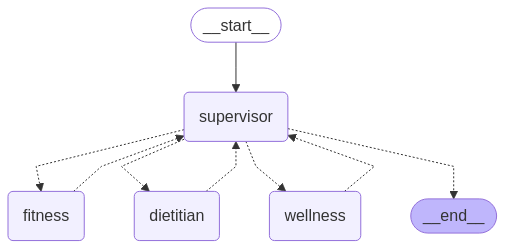

In [26]:
graph

#### Calling the Agents

In [27]:
def parse_langgraph_output(stream):
    results = []
    for key, value in stream.items():
        if key == "supervisor":
            continue
        messages = value.get("messages", [])
        for msg in messages:
            if isinstance(msg, str):
                results.append((key, msg))
            elif isinstance(msg, AIMessage):
                results.append((key, msg.content))
    return results

In [ ]:
"Can you give me a daily routine that includes meals, workouts, and stress relief?"

In [ ]:
# Get the final step in the stream
final_event = None
config = {"configurable": {"thread_id": "1", "recursion_limit": 10}}    
inputs = {
                "messages": [
                    HumanMessage(
                        content="Give me wellness tips for the month?"
                    )
                ],
            }


for step in graph.stream(inputs, config=config):
    final_event = step  # Keep updating to the latest step
    print(final_event)

    response_message=parse_langgraph_output(final_event)
    for agent, content in response_message:
        print(f"**Agent :** `{agent}`\n\n{content}")
        print("="*50)


{'supervisor': {'next': 'wellness'}}
{'wellness': {'messages': [AIMessage(content='Here\'s your wellness tip: **Tip:** Practice "Mindful Moments" throughout the day.\n\nInstead of trying to find large chunks of time for mindfulness, integrate short moments into your daily routine. Take a minute when you pause between tasks or during natural breaks in your schedule. Close your eyes, take three deep breaths, and focus solely on the sensation of breathing. This brief practice helps ground you and can significantly reduce stress throughout the day without feeling overwhelming to fit into a busy schedule.', additional_kwargs={}, response_metadata={}, name='wellness', id='e474b722-ae10-4e96-8f16-5ba14877db48')]}}
**Agent :** `wellness`

Here's your wellness tip: **Tip:** Practice "Mindful Moments" throughout the day.

Instead of trying to find large chunks of time for mindfulness, integrate short moments into your daily routine. Take a minute when you pause between tasks or during natural br

In [22]:
# Can you build a weekly workout routine for beginners?

In [ ]:
#HowcanIstayhealthy?